In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import seaborn as sns

In [2]:
# import dataset
df_train = pd.read_csv("af2_dataset_training_labeled.csv.gz", index_col=0)
df_train

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index,y_Ligand
0,M,False,False,False,False,False,False,False,False,False,...,0,0.0,47,-0.0,-26.499001,-4.742000,-35.189999,GEMI5_HUMAN,0,False
1,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-25.158001,-1.342000,-34.104000,GEMI5_HUMAN,1,False
2,Q,False,False,False,False,False,False,False,False,False,...,1,-0.0,-1,-0.0,-21.926001,-1.641000,-32.175999,GEMI5_HUMAN,2,False
3,E,False,False,False,True,False,False,False,False,False,...,706,-0.1,705,-0.0,-22.073999,0.654000,-29.171000,GEMI5_HUMAN,3,False
4,P,False,False,False,False,False,False,False,False,False,...,0,0.0,705,-0.2,-19.783001,2.670000,-26.858999,GEMI5_HUMAN,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,S,False,False,False,False,False,False,False,False,False,...,-3,-0.1,2,-0.4,-19.742001,20.796000,-12.319000,AOC3_HUMAN,755,False
756,H,False,False,False,False,False,False,True,False,False,...,-358,-0.1,-330,-0.1,-16.299000,19.153999,-12.640000,AOC3_HUMAN,756,False
757,G,False,False,False,False,False,True,False,False,False,...,-360,-0.2,-1,-0.1,-13.404000,19.502001,-10.121000,AOC3_HUMAN,757,False
758,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-10.986000,20.320000,-13.016000,AOC3_HUMAN,758,False


## Data Exploration

In [3]:
print(sum(df_train.y_Ligand == False))
print(sum(df_train.y_Ligand == True))

479912
17254


In [31]:
df_train.shape

(497166, 50)

### Dataset is imbalanced
- oversample
- undersample
- Ensemble different Resampled Datasets
- k-fold cross validation

In [4]:
features = df_train.drop(["y_Ligand"], axis=1)
labels = df_train["y_Ligand"]

In [33]:
correlations = features.corr()

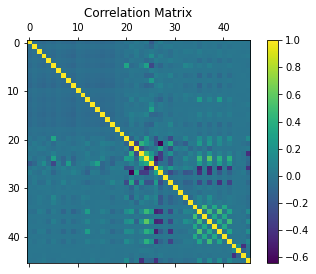

In [32]:
f = plt.figure()
plt.matshow(features.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix');

In [56]:
print(sum(((correlations.values.ravel() > 0.5) & (correlations.values.ravel() != 1))))
print(sum(correlations.values.ravel() < -0.6))

4
2


In [65]:
np.where(correlations.values.ravel() < -0.6)

(array([ 993, 1263], dtype=int64),)

In [80]:
np.where((correlations.values.ravel() > 0.5) & (correlations.values.ravel() != 1))

(array([1141, 1649, 1726, 1829], dtype=int64),)

In [85]:
correlations.columns[(int)(1649 % 46)]

'feat_DSSP_11'

In [87]:
print(correlations['feat_PSI']['feat_DSSP_H'])
print(correlations['feat_DSSP_9']['feat_BBSASA'])
print(correlations['feat_DSSP_7']['feat_DSSP_11'])

-0.6441074214031565
0.5859295090759643
0.554012707812967


In [126]:
null_count = sum(df_train.isnull().values).ravel()
null_count

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 12689,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [129]:
np.where(null_count > 0)

(array([21], dtype=int64),)

In [130]:
df_train.columns[21]

'annotation_atomrec'

In [135]:
sum(df_train['annotation_atomrec'].isnull())

12689

## Data Processing

In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

In [91]:
from collections import Counter

In [137]:
features = features.drop(['annotation_atomrec'], axis=1)

In [138]:
categorical_columns = [col for col in features.columns if features[col].dtype == 'O']
print(categorical_columns)

['annotation_sequence', 'entry']


In [145]:
features.columns

Index(['annotation_sequence', 'feat_A', 'feat_C', 'feat_D', 'feat_E', 'feat_F',
       'feat_G', 'feat_H', 'feat_I', 'feat_K', 'feat_L', 'feat_M', 'feat_N',
       'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T', 'feat_V', 'feat_W',
       'feat_Y', 'feat_PHI', 'feat_PSI', 'feat_TAU', 'feat_THETA',
       'feat_BBSASA', 'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_H',
       'feat_DSSP_B', 'feat_DSSP_E', 'feat_DSSP_G', 'feat_DSSP_I',
       'feat_DSSP_T', 'feat_DSSP_S', 'feat_DSSP_6', 'feat_DSSP_7',
       'feat_DSSP_8', 'feat_DSSP_9', 'feat_DSSP_10', 'feat_DSSP_11',
       'feat_DSSP_12', 'feat_DSSP_13', 'coord_X', 'coord_Y', 'coord_Z',
       'entry', 'entry_index'],
      dtype='object')

In [150]:
np.where((features.columns.values == 'annotation_sequence') | (features.columns.values == 'entry'))

(array([ 0, 46], dtype=int64),)

In [151]:
over = SMOTENC(categorical_features=[0, 46], sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

pipeline_sample = Pipeline(steps=[('o', over), ('u', under)])


In [152]:
X, y = pipeline_sample.fit_resample(features, labels.ravel())

In [154]:
Counter(labels)

Counter({False: 479912, True: 17254})

In [153]:
Counter(y)

Counter({False: 95982, True: 47991})

In [173]:
annotation_sequence = pd.get_dummies(X['annotation_sequence'], drop_first=True)
entry = pd.get_dummies(X['entry'], drop_first=True)

modified_X = X.drop(['annotation_sequence', 'entry'], axis = 1)
modified_X = pd.concat([modified_X, annotation_sequence], axis = 1)

In [174]:
print(annotation_sequence.shape)
print(entry.shape)

(143973, 19)
(143973, 722)


In [175]:
modified_X.shape

(143973, 65)

## Try some models

In [245]:
from sklearn import metrics
from sklearn.metrics import make_scorer

In [246]:
def make_auc_pr(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)
auc_pr = make_scorer(make_auc_pr)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=5000, class_weight='balanced')

In [243]:
pipeline = Pipeline(steps=[('m', lr)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring=['roc_auc', 'f1'], cv=cv, n_jobs=-1)

In [247]:
print(scores)

{'fit_time': array([151.43941116, 148.52268553, 148.35155249, 146.82406187,
       147.52183056, 148.55160832, 149.26986694, 149.91490865,
       151.21491647, 151.25202632, 147.64368248, 149.37364841,
       154.78728008, 154.5698576 , 153.03152609, 151.21790695,
       152.85698342, 151.95263958, 152.13628864, 153.06532931,
       146.87998414, 154.13362598, 152.51030564, 152.80949092,
        85.59752393,  83.77430391,  84.00187469,  83.26212239,
        84.14310956,  83.31252456]), 'score_time': array([0.53394413, 0.49428296, 0.40201092, 0.58583689, 0.48331237,
       0.50226331, 0.59552407, 0.5872426 , 0.43520021, 0.44510603,
       0.36510992, 0.58426237, 0.59406686, 0.45987248, 0.50931001,
       0.5706265 , 0.73076105, 0.48932934, 0.77616525, 0.37911272,
       0.6509304 , 0.38412642, 0.51429963, 0.36161947, 0.37909126,
       0.36660624, 0.34118199, 0.27883267, 0.20754051, 0.24893093]), 'test_roc_auc': array([0.85920579, 0.86130147, 0.84949777, 0.85921196, 0.85918076,
       0

### XGBoost

In [181]:
import xgboost 
xgb = xgboost.XGBClassifier()


In [183]:
from sklearn.model_selection import cross_validate

In [185]:
pipeline = Pipeline(steps=[('m', xgb)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring=['roc_auc', 'f1'], cv=cv, n_jobs=-1)

In [188]:
print(scores)

{'fit_time': array([177.071944  , 174.59308648, 181.28059173, 177.6214757 ,
       180.11805677, 166.2897613 , 173.3137691 , 164.31609845,
       172.06675673, 182.93936014, 167.46611071, 168.3264873 ,
       183.77984929, 176.72874975, 176.48544693, 175.75593996,
       168.62902737, 175.06731796, 165.77656531, 179.26742673,
       176.32944274, 170.23305917, 175.09380722, 168.11787057,
       102.67808127, 103.03128862, 100.92657399, 100.38533306,
       100.98281574,  97.88914394]), 'score_time': array([0.6276536 , 0.73747015, 0.85351872, 0.61127615, 0.59833026,
       0.60173321, 0.75224471, 0.76665521, 0.58333564, 0.93767309,
       0.77175856, 0.63494611, 0.59612155, 0.81568789, 0.60330367,
       0.82283449, 0.62820697, 0.83082986, 0.6095221 , 0.48853731,
       0.59607768, 0.59560275, 0.48519039, 0.60015965, 0.4313283 ,
       0.38013768, 0.34451342, 0.29869652, 0.26643109, 0.25338483]), 'test_roc_auc': array([0.95697389, 0.95459392, 0.95837299, 0.95823876, 0.95502512,
       0

In [251]:
pipeline = Pipeline(steps=[('m', xgb)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring={'roc_auc': 'roc_auc',
                                                         'f1': 'f1',
                                                         'auc_pr': auc_pr}, cv=cv, n_jobs=-1)

In [255]:
print(scores)

{'fit_time': array([170.17966175, 158.17194605, 159.03488493, 186.56607914,
       154.90738511, 167.098423  , 176.30840373, 173.14909291,
       158.51549244, 177.50608158, 177.34945679, 162.1239779 ,
       164.94279528, 157.45990896, 162.00630283, 166.7763288 ,
       182.9896009 , 167.31364155, 173.70886469, 175.48000741,
       175.35856318, 179.26983142, 161.71323848, 173.60699511,
       114.49064779, 112.07513237, 112.16786432, 108.00348401,
       104.17497969,  98.54341912]), 'score_time': array([0.58091497, 0.78441286, 0.62737989, 0.60102272, 0.75563788,
       0.56448102, 0.56435776, 0.77004266, 0.59653282, 0.56539178,
       0.58048916, 0.5965271 , 0.77477527, 0.56890845, 0.57774925,
       0.68144321, 0.59653759, 0.73659801, 0.60250711, 0.62843466,
       0.55570817, 0.46063232, 0.59652734, 0.47897124, 0.44202757,
       0.38384461, 0.34624362, 0.38562369, 0.3248136 , 0.25479078]), 'test_roc_auc': array([0.95697389, 0.95459392, 0.95837299, 0.95823876, 0.95502512,
       0

### RandomForest

In [189]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier()

In [190]:
pipeline = Pipeline(steps=[('m', rf)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring=['roc_auc', 'f1'], cv=cv, n_jobs=-1)

In [191]:
print(scores)

{'fit_time': array([139.32483244, 145.73354483, 132.26152802, 128.90371704,
       128.7939508 , 128.77832341, 132.10489535, 135.08932972,
       138.82246614, 127.47626519, 143.93759537, 138.10048842,
       122.51007533, 132.4314127 , 140.58974814, 136.4311316 ,
       142.29103589, 131.29991937, 149.15325999, 129.45667768,
       122.94607639, 135.20798063, 138.41315198, 134.22465229,
        86.32518744,  80.76581192,  81.11117983,  79.22892046,
        78.58404326,  77.60858774]), 'score_time': array([2.42153692, 2.40145278, 2.41749787, 2.36851835, 2.76074338,
       2.66659665, 2.98443437, 2.90549684, 2.59418321, 2.33733177,
       2.40810752, 2.48487759, 2.41082621, 2.49439144, 2.95690155,
       2.38509703, 2.32845712, 2.44657254, 1.58469033, 2.4549377 ,
       2.41530776, 2.40698385, 1.86725903, 2.14852381, 1.41556501,
       1.36477757, 1.3188498 , 1.20757651, 1.13453507, 0.90980554]), 'test_roc_auc': array([0.9664545 , 0.96621014, 0.96779518, 0.96747262, 0.96433145,
       0

In [249]:
pipeline = Pipeline(steps=[('m', rf)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring={'roc_auc': 'roc_auc',
                                                         'f1': 'f1',
                                                         'auc_pr': auc_pr}, cv=cv, n_jobs=-1)

In [250]:
print(scores)

{'fit_time': array([124.20286083, 152.99761891, 152.39309263, 145.55378795,
       137.15268421, 129.23335981, 150.70422101, 135.79511261,
       139.63588595, 140.43138433, 143.60544038, 128.0762012 ,
       136.01605153, 150.28573585, 142.25198078, 119.82839131,
       132.03406549, 137.706774  , 133.88104892, 135.48464036,
       127.5899322 , 137.51693344, 127.20411777, 123.1000247 ,
        82.9584341 ,  80.83569407,  76.32688737,  74.96695256,
        73.5593226 ,  72.97401929]), 'score_time': array([2.35119486, 3.21556258, 2.35074472, 2.52774715, 2.50478125,
       2.45842171, 2.3775599 , 2.33234525, 3.2027638 , 2.36847091,
       3.20998955, 2.62406468, 2.55720115, 2.38516021, 3.17963767,
       2.34258747, 3.0588429 , 2.61918235, 3.31087303, 2.30586433,
       2.33282375, 1.61514521, 2.4047308 , 2.36801744, 1.4279294 ,
       1.30275822, 1.17667842, 1.08233356, 1.20220971, 0.86321807]), 'test_roc_auc': array([0.96671702, 0.96559719, 0.96684984, 0.96752599, 0.96500028,
       0

### Neural Network

In [192]:
from sklearn.model_selection import train_test_split

In [210]:
tensor_X = 1 * modified_X

In [237]:
tensor_X.head()

,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,feat_L,...,M,N,P,Q,R,S,T,V,W,Y
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [196]:
import tensorflow as tf

In [198]:
import tensorflow_addons as tfa

In [239]:
def create_model():
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(200, activation='relu', input_dim=65))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.AUC(),
                           tfa.metrics.F1Score(num_classes=1, average='macro',threshold=0.5)])
    return model

In [201]:
class_weight = {False: 1.,
                True: 2.}

In [232]:
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier

In [241]:
pipeline = Pipeline(steps=[('standardize', StandardScaler()), 
                           ('mlp', KerasClassifier(model=create_model, class_weight=class_weight, epochs=200, batch_size=512, verbose=0))])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_val_score(pipeline, tensor_X, y, cv=cv, n_jobs=-1)

In [242]:
print(scores)

[0.76135574 0.75704959 0.7750382  0.76981316 0.73841773 0.76460374
 0.7697437  0.76022783 0.77356394 0.76897965 0.76121684 0.75968885
 0.76705098 0.7619643  0.74967007 0.76578454 0.78141279 0.76752101
 0.76765993 0.76029728 0.77045423 0.77781636 0.74774274 0.76995207
 0.75328193 0.74390498 0.75064249 0.76710426 0.77224422 0.78870598]


### LightGBM

In [256]:
import lightgbm as lgb

In [267]:
pipeline = Pipeline(steps=[('m', lgb.LGBMClassifier(objective='binary', learning_rate=0.03))])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring={'roc_auc': 'roc_auc',
                                                         'f1': 'f1',
                                                         'auc_pr': auc_pr}, cv=cv, n_jobs=-1)

In [268]:
print(scores)

{'fit_time': array([10.42995429, 10.25728559, 11.24571776, 10.26689625,  8.68745995,
        8.74037528,  9.77043915, 12.89805794, 11.62240148, 10.36705518,
       11.76385427,  9.0701561 ,  8.2391026 ,  8.99649811,  9.23670578,
        8.22072053, 10.00617099,  9.42885327, 10.58436036,  9.70804644,
       11.03943825, 10.04390788,  9.94937062,  9.26014256,  7.48871207,
        7.53425097,  7.28819585,  6.98631525,  6.32651901,  6.31945992]), 'score_time': array([0.70593882, 0.65862393, 0.92014575, 0.67468548, 0.73051906,
       0.71445894, 0.705971  , 0.63200045, 0.88790202, 0.70593882,
       0.96601844, 0.66947746, 0.71418691, 0.81489873, 0.74663639,
       0.68031502, 1.05276608, 0.73918843, 0.80728745, 0.6711688 ,
       0.77261114, 0.86933327, 0.73529124, 0.72672296, 0.59011579,
       0.46826935, 0.47418261, 0.45264244, 0.33527994, 0.31500602]), 'test_roc_auc': array([0.93030239, 0.92770672, 0.92955369, 0.92853109, 0.92488957,
       0.92669023, 0.92609797, 0.92730484, 0.9323793

In [265]:
### after standardize
print(scores)

{'fit_time': array([14.18041754, 16.16266942, 12.89290285, 11.95224524, 12.87726665,
       13.59948587, 12.87730193, 16.28848219, 13.48864579, 15.37756658,
       13.58345556, 16.08415914, 12.0511837 , 12.08141279, 12.9766283 ,
       17.06989312, 13.14117146, 17.24790072, 13.03148103, 12.37980151,
       12.90174031, 11.95962691, 15.65749288, 15.61014223, 10.09392571,
       10.22953629,  9.22223926,  9.00163889,  9.02131081,  8.94122076]), 'score_time': array([0.84739685, 1.03620934, 0.9260962 , 0.87773776, 0.91048002,
       1.09915662, 0.9260962 , 1.22415257, 0.94201779, 1.01967502,
       1.1458261 , 1.22453022, 0.81572175, 0.89479113, 0.9338665 ,
       0.90046096, 0.9420321 , 0.8943336 , 0.89476109, 0.93415833,
       0.88290548, 0.96145129, 0.70579863, 0.64334035, 0.64333439,
       0.5326705 , 0.54871297, 0.53263164, 0.39723897, 0.42075849]), 'test_roc_auc': array([0.92971291, 0.92774086, 0.92930604, 0.92962967, 0.92591745,
       0.92663974, 0.92721174, 0.9278327 , 0.9313325

### VotingClassifier

In [266]:
from sklearn.ensemble import VotingClassifier

In [272]:
p1 = Pipeline(steps=[('m', rf)])
p2 = Pipeline(steps=[('m', xgb)])
p3 = Pipeline(steps=[('m', lr)])

In [279]:
evc = VotingClassifier(estimators=[('lr',p3),('rf',p1),('xgb',p2)], voting='soft')

In [282]:
pipeline = Pipeline(steps=[('m', evc)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=20902490)
scores = cross_validate(pipeline, modified_X, y, scoring={'roc_auc': 'roc_auc',
                                                         'f1': 'f1',
                                                         'auc_pr': auc_pr}, cv=cv, n_jobs=-1, error_score="raise")

In [283]:
print(scores)

{'fit_time': array([478.68087387, 451.75876641, 436.84960151, 464.81938434,
       433.08149791, 448.98172212, 456.79750633, 453.14655185,
       431.84534168, 436.10888839, 448.21726537, 458.00946689,
       493.56793189, 453.8081851 , 484.5783143 , 455.63740182,
       455.09887052, 454.68513656, 450.39687538, 453.27141213,
       477.0117259 , 460.97782755, 460.5413444 , 442.8023572 ,
       252.57471585, 252.17810845, 246.96362925, 248.37135196,
       246.30180669, 245.40648746]), 'score_time': array([5.54240441, 4.00166225, 3.9741509 , 5.50061512, 3.40498543,
       5.36156154, 4.59407187, 4.05148101, 3.32969427, 4.88751149,
       5.58500242, 4.34517598, 4.73993754, 3.5030427 , 5.40686178,
       3.86519718, 3.75796437, 3.82176614, 5.12117791, 3.83874607,
       3.80250406, 5.0407548 , 4.62667346, 4.96939921, 2.18925166,
       2.17094302, 1.73084784, 1.63545704, 1.63887095, 1.62500477]), 'test_roc_auc': array([0.9584125 , 0.95729371, 0.95799018, 0.9594075 , 0.95517297,
       0

In [ ]:
df_test = pd.read_csv("af2_dataset_testset_unlabeled.csv.gz", index_col=0)
df_test

y_test_submission = xgb.predict(df_test[without_categorical_columns])

s = pd.Series(y_test_submission).astype(bool)
s.name = "Predicted"
s.to_csv("submission.csv")